<a href="https://colab.research.google.com/github/muhafidz-ahmad/ecommerce-product-recommender-system/blob/main/Ecommerce_Product_Recommender_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sistem Rekomendasi Produk E-commerce

# Packages Preparation

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Data Collecting

## Import dari Kaggle

Dataset yang digunakan adalah dataset dari [kaggle](https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce) tentang riwayat transaksi, pelanggan, dan item marketplace di Brazil.

Referensi: https://medium.com/codex/tensorflow-deep-learning-recommenders-on-retail-dataset-ce0c50aff5f

In [ ]:
# siapkan API Kaggle
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!cp '/content/drive/MyDrive/Colab Notebooks/kaggle.json' ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# download dataset dari kaggle
!kaggle datasets download -d olistbr/brazilian-ecommerce

# ekstrak hasil download dataset dari kaggle
!unzip /content/brazilian-ecommerce.zip -d /content/

rm: cannot remove '/root/.kaggle': No such file or directory
 73% 31.0M/42.6M [00:00<00:00, 129MB/s]
100% 42.6M/42.6M [00:00<00:00, 145MB/s]
Archive:  /content/brazilian-ecommerce.zip
  inflating: /content/olist_customers_dataset.csv  
  inflating: /content/olist_geolocation_dataset.csv  
  inflating: /content/olist_order_items_dataset.csv  
  inflating: /content/olist_order_payments_dataset.csv  
  inflating: /content/olist_order_reviews_dataset.csv  
  inflating: /content/olist_orders_dataset.csv  
  inflating: /content/olist_products_dataset.csv  
  inflating: /content/olist_sellers_dataset.csv  
  inflating: /content/product_category_name_translation.csv  


## Dataframe

![dataset](https://i.imgur.com/HRhd2Y0.png)

Terdapat 9 skema dataset yang tersedia. Namun pada project ini hanya akan digunakan 6 skema dataset, yaitu:
1. olist_order_customers_dataset.csv
2. olist_order_items_dataset.csv
3. olist_order_reviews_dataset.csv
4. olist_orders_dataset.csv
5. olist_seller_dataset.csv
6. olist_products_dataset.csv
7. product_category_name_translation.csv

In [ ]:
raw_cust = pd.read_csv('/content/olist_customers_dataset.csv')
# raw_geoloc = pd.read_csv('/content/olist_geolocation_dataset.csv')
raw_order_items = pd.read_csv('/content/olist_order_items_dataset.csv')
# raw_order_payments = pd.read_csv('/content/olist_order_payments_dataset.csv')
raw_order_reviews = pd.read_csv('/content/olist_order_reviews_dataset.csv')
raw_orders = pd.read_csv('/content/olist_orders_dataset.csv')
raw_products = pd.read_csv('/content/olist_products_dataset.csv')
raw_sellers = pd.read_csv('/content/olist_sellers_dataset.csv')
product_cats_translation = pd.read_csv('/content/product_category_name_translation.csv')

print('Dimensi data raw_cust:', raw_cust.shape,
      '\n\t', list(raw_cust.columns))
# print('\nDimensi data raw_geoloc:', raw_geoloc.shape, '\n\t', list(raw_geoloc.columns))
print('\nDimensi data raw_order_items:', raw_order_items.shape,
      '\n\t', list(raw_order_items.columns))
# print('\nDimensi data raw_order_payments:', raw_order_payments.shape, '\n\t', list(raw_order_payments.columns))
print('\nDimensi data raw_order_reviews:', raw_order_reviews.shape,
      '\n\t', list(raw_order_reviews.columns))
print('\nDimensi data raw_orders:', raw_orders.shape, '\n\t', list(raw_orders.columns))
print('\nDimensi data raw_products:', raw_products.shape,
      '\n\t', list(raw_products.columns))
print('\nDimensi data raw_sellers:', raw_sellers.shape, '\n\t', list(raw_sellers.columns))
print('\nDimensi data product_cats_translation:', product_cats_translation.shape,
      '\n\t', list(product_cats_translation.columns))

Dimensi data raw_cust: (99441, 5) 
	 ['customer_id', 'customer_unique_id', 'customer_zip_code_prefix', 'customer_city', 'customer_state']

Dimensi data raw_order_items: (112650, 7) 
	 ['order_id', 'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date', 'price', 'freight_value']

Dimensi data raw_order_reviews: (99224, 7) 
	 ['review_id', 'order_id', 'review_score', 'review_comment_title', 'review_comment_message', 'review_creation_date', 'review_answer_timestamp']

Dimensi data raw_orders: (99441, 8) 
	 ['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']

Dimensi data raw_products: (32951, 9) 
	 ['product_id', 'product_category_name', 'product_name_lenght', 'product_description_lenght', 'product_photos_qty', 'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm']

Dimensi data raw_sellers: (3095, 4) 
	 ['seller_i

# Univariate EDA

## Order customers dataset

Pertama akan dieksplorasi data customers dengan mengecek apakah ada missing value dan duplicated data.

In [ ]:
raw_cust.isna().sum()

customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

In [ ]:
raw_cust.duplicated().sum()

0

Data customers tidak ada data yang kosong dan tidak ada data duplikat.

Untuk menyederhanakan data, informasi lokasi yang digunakan hanyalah kota customers (_customer_city_)

In [ ]:
raw_cust.drop(['customer_zip_code_prefix', 'customer_state'], axis=1,
              inplace=True)
raw_cust.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   customer_id         99441 non-null  object
 1   customer_unique_id  99441 non-null  object
 2   customer_city       99441 non-null  object
dtypes: object(3)
memory usage: 2.3+ MB


Selanjutnya akan dilihat nilai unik tiap kolom.

In [ ]:
print('Jumlah customers: ', len(raw_cust.customer_id.unique()))
print('Jumlah customers unik: ', len(raw_cust.customer_unique_id.unique()))
print('Jumlah kota unik:', len(raw_cust.customer_city.unique()))

Jumlah customers:  99441
Jumlah customers unik:  96096
Jumlah kota unik: 4119


<Axes: title={'center': 'Jumlah pembeli tiap kota'}>

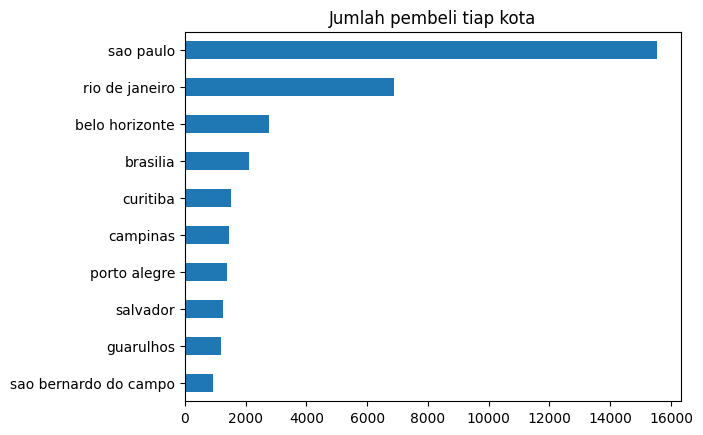

In [ ]:
raw_cust.customer_city.value_counts()[:10].sort_values(ascending=True).plot(kind='barh',
                                                                            title='Jumlah pembeli tiap kota')

## Order items dataset

Seperti biasa, cek dulu kondisi data

In [ ]:
raw_order_items.isna().sum()

order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64

In [ ]:
raw_order_items.duplicated().sum()

0

Kolom *shipping_limit_date* akan dihapus karena tidak akan digunakan.

In [ ]:
raw_order_items.drop(['shipping_limit_date'], axis=1,
                     inplace=True)
raw_order_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   order_id       112650 non-null  object 
 1   order_item_id  112650 non-null  int64  
 2   product_id     112650 non-null  object 
 3   seller_id      112650 non-null  object 
 4   price          112650 non-null  float64
 5   freight_value  112650 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 5.2+ MB


Selanjutnya akan dilihat nilai unik tiap kolom.

In [ ]:
print('Jumlah order_id: ', len(raw_order_items.order_id.unique()))
print('Jumlah order_item_id: ', len(raw_order_items.order_item_id.unique()))
print('Jumlah product_id: ', len(raw_order_items.product_id.unique()))
print('Jumlah seller_id: ', len(raw_order_items.seller_id.unique()))
print('Jumlah price: ', len(raw_order_items.price.unique()))
print('Jumlah freight_value: ', len(raw_order_items.freight_value.unique()))

Jumlah order_id:  98666
Jumlah order_item_id:  21
Jumlah product_id:  32951
Jumlah seller_id:  3095
Jumlah price:  5968
Jumlah freight_value:  6999


Selanjutnya akan dilihat statistik deskriptif dari kolom dengan tipe data numerik, yaitu total harga

In [ ]:
raw_order_items.describe()

,order_item_id,price,freight_value
count,112650.000000,112650.000000,112650.000000
mean,1.197834,120.653739,19.990320
std,0.705124,183.633928,15.806405
min,1.000000,0.850000,0.000000
25%,1.000000,39.900000,13.080000
50%,1.000000,74.990000,16.260000
75%,1.000000,134.900000,21.150000
max,21.000000,6735.000000,409.680000


Eksplor sedikit lebih dalam variabel *order_item_id*

In [ ]:
raw_order_items.order_item_id.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21])

In [ ]:
raw_order_items[raw_order_items.order_item_id == 5]

,order_id,order_item_id,product_id,seller_id,price,freight_value
562,0148d3df00cebda592d4e5f966e300cc,5,ed08ea04c92f5f434c2362f7310fb328,0adac9fbd9a2b63cccaac4f8756c1ca8,5.53,11.85
1136,02a065131a2d2b72b45e2c63135606ad,5,993245facdeea0014e73a3e18750c123,1025f0e2d44d7041d6cf58b6550e0bfa,125.00,26.95
1241,02e0c2efb6d9bb2a95ca90b7e78bec1f,5,f4041d76285c2a34ad5013e8d287a400,1835b56ce799e6a4dc4eddc053f04066,39.99,12.79
1502,03705afa0a4aabe1a734ddb11c1df3f0,5,b40ec43bdfc6d6fdd65e882066a5c895,897060da8b9a21f655304d50fd935913,177.00,27.78
1597,03aba68b07658f28f29612641f08d4ba,5,e7cc48a9daff5436f63d3aad9426f28b,53243585a1d6dc2643021fd1853d8905,170.00,30.44
...,...,...,...,...,...,...
110570,fb3cf8c9eb2412b0edc0a00a8f43a869,5,4cceacaeb21aa22aa51b4c724de3758d,157c3e4b42f81ac4a44e8b1ca2fe9876,90.00,8.22
110677,fb7d6ea70e823cfb1afca3524282cbf9,5,53759a2ecddad2bb87a079a1f1519f73,1f50f920176fa81dab994f9023523100,53.90,21.35
110720,fb8e4428d340ab5bfa482ef6fc97efbc,5,53b36df67ebb7c41585e8d54d6772e08,4869f7a5dfa277a7dca6462dcf3b52b2,169.90,12.69
110895,fbf6a5df377654baa14f40156140e563,5,98a4301b1aacd45984603af55b7a1de4,1900267e848ceeba8fa32d80c1a5f5a8,53.00,13.73


In [ ]:
raw_order_items[raw_order_items.order_id == '02a065131a2d2b72b45e2c63135606ad']

,order_id,order_item_id,product_id,seller_id,price,freight_value
1132,02a065131a2d2b72b45e2c63135606ad,1,993245facdeea0014e73a3e18750c123,1025f0e2d44d7041d6cf58b6550e0bfa,125.0,26.95
1133,02a065131a2d2b72b45e2c63135606ad,2,993245facdeea0014e73a3e18750c123,1025f0e2d44d7041d6cf58b6550e0bfa,125.0,26.95
1134,02a065131a2d2b72b45e2c63135606ad,3,993245facdeea0014e73a3e18750c123,1025f0e2d44d7041d6cf58b6550e0bfa,125.0,26.95
1135,02a065131a2d2b72b45e2c63135606ad,4,993245facdeea0014e73a3e18750c123,1025f0e2d44d7041d6cf58b6550e0bfa,125.0,26.95
1136,02a065131a2d2b72b45e2c63135606ad,5,993245facdeea0014e73a3e18750c123,1025f0e2d44d7041d6cf58b6550e0bfa,125.0,26.95


Kolom *order_item_id* akan dihapus karena tidak akan digunakan.

In [ ]:
raw_order_items.drop('order_item_id', axis=1, inplace=True)
raw_order_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   order_id       112650 non-null  object 
 1   product_id     112650 non-null  object 
 2   seller_id      112650 non-null  object 
 3   price          112650 non-null  float64
 4   freight_value  112650 non-null  float64
dtypes: float64(2), object(3)
memory usage: 4.3+ MB


## Order reviews dataset

In [ ]:
raw_order_reviews.isna().sum()

review_id                      0
order_id                       0
review_score                   0
review_comment_title       87656
review_comment_message     58247
review_creation_date           0
review_answer_timestamp        0
dtype: int64

In [ ]:
raw_order_reviews.duplicated().sum()

0

Terdapat review yang tidak menggunakan pesan atau komentar, hanya berupa skor. Namun project ini hanya akan mengambil skor review saja tanpa menggunakan pesan atau komentar reviewnya, maka kolom *review_comment_title* dan *review_comment_message* akan dihapus.

In [ ]:
raw_order_reviews.drop(['review_comment_title', 'review_comment_message'],
                       axis=1, inplace=True)
raw_order_reviews.head()

,review_id,order_id,review_score,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,2018-03-01 00:00:00,2018-03-02 10:26:53


Selanjutnya kolom *review_creation_date* dan *review_answer_timestamp* akan dihapus.

In [ ]:
raw_order_reviews.drop(['review_creation_date', 'review_answer_timestamp'], 
                       axis=1, inplace=True)

raw_order_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   review_id     99224 non-null  object
 1   order_id      99224 non-null  object
 2   review_score  99224 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.3+ MB


In [ ]:
raw_order_reviews.describe()

,review_score
count,99224.000000
mean,4.086421
std,1.347579
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


## Orders dataset

In [ ]:
raw_orders.duplicated().sum()

0

In [ ]:
raw_orders.isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

In [ ]:
raw_orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


<Axes: title={'center': 'order_status'}>

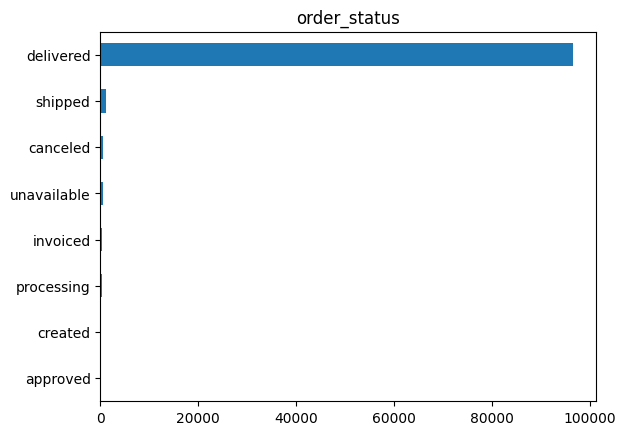

In [ ]:
raw_orders.order_status.value_counts().sort_values(ascending=True).plot(kind='barh', title='order_status')

Hanya akan digunakan order yang statusnya delivered.

In [ ]:
raw_orders = raw_orders[raw_orders.order_status == 'delivered']
raw_orders.isna().sum()

order_id                          0
customer_id                       0
order_status                      0
order_purchase_timestamp          0
order_approved_at                14
order_delivered_carrier_date      2
order_delivered_customer_date     8
order_estimated_delivery_date     0
dtype: int64

Karena nilai yang kosong hanya 14 baris, maka nilai yang kosong ini akan disingkirkan.

In [ ]:
raw_orders.dropna(inplace=True)

Kolom *order_purchase_timestamp*, *order_approved_at* akan digunakan untuk membuat fitur baru lama respon penjual terhadap sebuah order

Sedangkan kolom *order_delivered_carrier_date*, *order_delivered_customer_date*, dan *order_estimated_delivery_date* akan dihapus. Begitu pula kolom *order_status* akan dihapus.

In [ ]:
raw_orders.drop(['order_status',
                 'order_delivered_carrier_date',
                 'order_delivered_customer_date',
                 'order_estimated_delivery_date'],
                axis=1, inplace=True)

raw_orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96455 entries, 0 to 99440
Data columns (total 4 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   order_id                  96455 non-null  object
 1   customer_id               96455 non-null  object
 2   order_purchase_timestamp  96455 non-null  object
 3   order_approved_at         96455 non-null  object
dtypes: object(4)
memory usage: 3.7+ MB


In [ ]:
raw_orders['order_purchase_timestamp'] = pd.to_datetime(raw_orders.order_purchase_timestamp,
                                                        format="%Y-%m-%d %H:%M:%S")
raw_orders['order_approved_at'] = pd.to_datetime(raw_orders.order_approved_at,
                                                 format="%Y-%m-%d %H:%M:%S")

raw_orders['respons_time_order'] = raw_orders.order_approved_at - raw_orders.order_purchase_timestamp

raw_orders.drop(['order_purchase_timestamp', 'order_approved_at'], axis=1, inplace=True)

raw_orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96455 entries, 0 to 99440
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype          
---  ------              --------------  -----          
 0   order_id            96455 non-null  object         
 1   customer_id         96455 non-null  object         
 2   respons_time_order  96455 non-null  timedelta64[ns]
dtypes: object(2), timedelta64[ns](1)
memory usage: 2.9+ MB


## Seller dataset

In [ ]:
raw_sellers.duplicated().sum()

0

In [ ]:
raw_sellers.isna().sum()

seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

Karena informasi lokasi customer yang digunakan hanya informasi kota, maka informasi lokasi seller juga hanya akan menggunakan informasi kota.

In [ ]:
raw_sellers.drop(['seller_zip_code_prefix', 'seller_state'], axis=1, inplace=True)
raw_sellers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3095 entries, 0 to 3094
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   seller_id    3095 non-null   object
 1   seller_city  3095 non-null   object
dtypes: object(2)
memory usage: 48.5+ KB


In [ ]:
print('Jumlah seller unik:', len(raw_sellers.seller_id.unique()))
print('Jumlah kota seller unik:', len(raw_sellers.seller_city.unique()))

Jumlah seller unik: 3095
Jumlah kota seller unik: 611


<Axes: title={'center': 'Top 10 kota dengan penjual terbanyak'}>

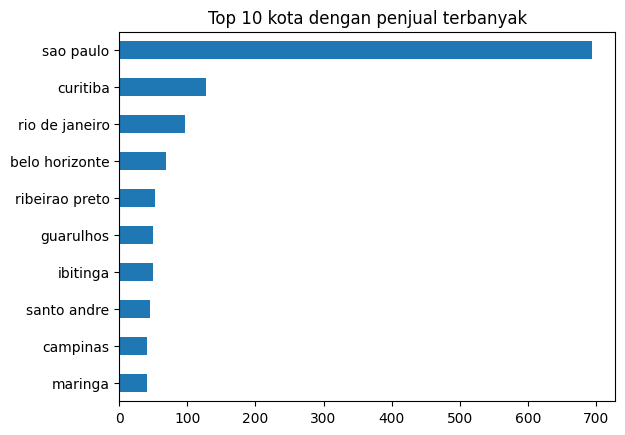

In [ ]:
raw_sellers.seller_city.value_counts()[:10].sort_values(ascending=True).plot(kind='barh',
                                                                             title='Top 10 kota dengan penjual terbanyak')

## Products dataset

In [ ]:
raw_products.duplicated().sum()

0

In [ ]:
raw_products.isna().sum()

product_id                      0
product_category_name         610
product_name_lenght           610
product_description_lenght    610
product_photos_qty            610
product_weight_g                2
product_length_cm               2
product_height_cm               2
product_width_cm                2
dtype: int64

In [ ]:
raw_products.shape

(32951, 9)

Terdapat beberapa produk yang nama kategori, nama produk, deskripsi, dan fotonya hilang. Namun karena jumlahnya sedikit, akan dihapus saja.

Sebelum itu, akan dihapus dulu kolom *product_name_length* dan *product_description_length*.

In [ ]:
raw_products.drop(['product_name_lenght', 'product_description_lenght'],
                  axis=1, inplace=True)

raw_products.dropna(inplace=True)

raw_products.isna().sum()

product_id               0
product_category_name    0
product_photos_qty       0
product_weight_g         0
product_length_cm        0
product_height_cm        0
product_width_cm         0
dtype: int64

In [ ]:
raw_products.product_category_name.unique()

array(['perfumaria', 'artes', 'esporte_lazer', 'bebes',
       'utilidades_domesticas', 'instrumentos_musicais', 'cool_stuff',
       'moveis_decoracao', 'eletrodomesticos', 'brinquedos',
       'cama_mesa_banho', 'construcao_ferramentas_seguranca',
       'informatica_acessorios', 'beleza_saude', 'malas_acessorios',
       'ferramentas_jardim', 'moveis_escritorio', 'automotivo',
       'eletronicos', 'fashion_calcados', 'telefonia', 'papelaria',
       'fashion_bolsas_e_acessorios', 'pcs', 'casa_construcao',
       'relogios_presentes', 'construcao_ferramentas_construcao',
       'pet_shop', 'eletroportateis', 'agro_industria_e_comercio',
       'moveis_sala', 'sinalizacao_e_seguranca', 'climatizacao',
       'consoles_games', 'livros_interesse_geral',
       'construcao_ferramentas_ferramentas',
       'fashion_underwear_e_moda_praia', 'fashion_roupa_masculina',
       'moveis_cozinha_area_de_servico_jantar_e_jardim',
       'industria_comercio_e_negocios', 'telefonia_fixa',
       '

Karena kategori produk masih dalam Bahasa Portugis, agar kita lebih mudah membacanya, akan diubah menjadi Bahasa Inggris.

In [ ]:
dict_product = dict(zip(product_cats_translation.product_category_name,
                        product_cats_translation.product_category_name_english))

raw_products.replace({'product_category_name': dict_product}, inplace=True)
raw_products.head()

,product_id,product_category_name,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumery,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,art,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,sports_leisure,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,baby,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,housewares,4.0,625.0,20.0,17.0,13.0


<Axes: title={'center': 'Top 10 kategori produk'}>

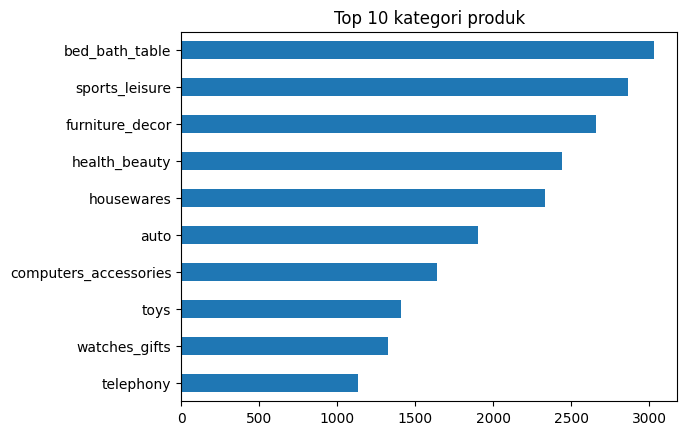

In [ ]:
raw_products.product_category_name.value_counts()[:10].sort_values(ascending=True).plot(kind='barh',
                                                                                        title='Top 10 kategori produk')

# Data Preprocessing

1. customers
  * customer_id
  * customer_unique_id
  * customer_city
2. order items
  * order_id
  * product_id
  * seller_id
  * price
  * freight_value
3. order_reviews
  * review_id
  * order_id
  * review_score
  * respons_time_review
4. orders
  * order_id
  * customer_id
  * respons_time_order
5. sellers
  * seller_id
  * seller_city
6. product_id
  * product_id
  * product_category_name
  * product_photos_qty
  * product_weight_g
  * product_length_cm
  * product_height_cm
  * product_width_cm

Karena dataset tidak menyediakan nama produk dan nama seller yang asli, maka akan dibuat nama produk dan seller buatan secara random untuk mempermudah membaca produk

## Membuat nama product buatan

In [ ]:
product_all = np.concatenate((
    raw_order_items.product_id.unique(),
    raw_products.product_id.unique()
))

product_all = np.sort(np.unique(product_all))

product_name = ('product_' + str(i) for i in range(len(product_all)))

product_name_dict = dict(zip(product_all, product_name))

print('Jumlah total produk unik:', len(product_name_dict))

Jumlah total produk unik: 32951


In [ ]:
raw_order_items.replace({'product_id': product_name_dict}, inplace=True)
raw_products.replace({'product_id': product_name_dict}, inplace=True)
raw_order_items.head()

,order_id,product_id,seller_id,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,product_8628,48436dade18ac8b2bce089ec2a041202,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,product_29597,dd7ddc04e1b6c2c614352b383efe2d36,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,product_25667,5b51032eddd242adc84c38acab88f23d,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,product_15322,9d7a1d34a5052409006425275ba1c2b4,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,product_22079,df560393f3a51e74553ab94004ba5c87,199.90,18.14


## Membuat nama seller buatan

In [ ]:
seller_all = np.concatenate((
    raw_order_items.seller_id.unique(),
    raw_sellers.seller_id.unique()
))

seller_all = np.sort(np.unique(seller_all))

seller_name = {'seller_' + str(i) for i in range(len(seller_all))}

seller_name_dict = dict(zip(seller_all, seller_name))

print('Jumlah total seller unik:', len(seller_name_dict))

Jumlah total seller unik: 3095


In [ ]:
raw_order_items.replace({'seller_id': seller_name_dict}, inplace=True)
raw_sellers.replace({'seller_id': seller_name_dict}, inplace=True)
raw_sellers.head()

,seller_id,seller_city
0,seller_2579,campinas
1,seller_143,mogi guacu
2,seller_1023,rio de janeiro
3,seller_3088,sao paulo
4,seller_833,braganca paulista


## Harga product

Terkadang harga produk berubah-ubah. Sehingga akan diambil harga rata-ratanya saja.

In [ ]:
price_products = raw_order_items[['product_id', 'price']]

price_products = price_products.groupby('product_id').mean().reset_index()

products = pd.merge(raw_products, price_products, on='product_id', how='left')
products.sample(3)

,product_id,product_category_name,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,price
24196,product_20050,sports_leisure,3.0,10150.0,20.0,20.0,20.0,69.99
27657,product_8948,auto,4.0,1900.0,41.0,45.0,11.0,256.00
29275,product_9007,bed_bath_table,1.0,1200.0,45.0,15.0,35.0,89.90


In [ ]:
products.isna().sum()

product_id               0
product_category_name    0
product_photos_qty       0
product_weight_g         0
product_length_cm        0
product_height_cm        0
product_width_cm         0
price                    0
dtype: int64

## Review dan jumlah product terjual

In [ ]:
rating_order = pd.merge(raw_order_items, raw_order_reviews[['order_id', 'review_score']],
                        on='order_id', how='left')[['product_id', 'review_score']]

rating_products = rating_order.groupby('product_id').mean().round(1).reset_index()
sold_products = rating_order.groupby('product_id').count().reset_index()

rating_sold = pd.merge(rating_products, sold_products, on='product_id',
                       how='left')

rating_sold.rename(columns={'review_score_x': 'review_score',
                            'review_score_y': 'sold'},
                   inplace=True)

products = pd.merge(products, rating_sold, on='product_id', how='left')
products.head()

,product_id,product_category_name,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,price,review_score,sold
0,product_4053,perfumery,1.0,225.0,16.0,10.0,14.0,10.91,5.0,1
1,product_7645,art,1.0,1000.0,30.0,18.0,20.0,248.00,5.0,1
2,product_19351,sports_leisure,1.0,154.0,18.0,9.0,15.0,79.80,5.0,1
3,product_26672,baby,1.0,371.0,26.0,4.0,26.0,112.30,1.0,1
4,product_20305,housewares,4.0,625.0,20.0,17.0,13.0,37.90,5.0,1


In [ ]:
products.isna().sum()

product_id                 0
product_category_name      0
product_photos_qty         0
product_weight_g           0
product_length_cm          0
product_height_cm          0
product_width_cm           0
price                      0
review_score             157
sold                       0
dtype: int64

Terdapat 157 produk yang belum memiliki review walau sudah terjual.

## Masukan nama seller ke products

In [ ]:
seller_products = raw_order_items.drop_duplicates(['product_id'])[['product_id',
                                                                   'seller_id']]

products = pd.merge(products, seller_products, on='product_id', how='left')
products.head()

,product_id,product_category_name,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,price,review_score,sold,seller_id
0,product_4053,perfumery,1.0,225.0,16.0,10.0,14.0,10.91,5.0,1,seller_993
1,product_7645,art,1.0,1000.0,30.0,18.0,20.0,248.00,5.0,1,seller_862
2,product_19351,sports_leisure,1.0,154.0,18.0,9.0,15.0,79.80,5.0,1,seller_2969
3,product_26672,baby,1.0,371.0,26.0,4.0,26.0,112.30,1.0,1,seller_350
4,product_20305,housewares,4.0,625.0,20.0,17.0,13.0,37.90,5.0,1,seller_1040


In [ ]:
products.isna().sum()

product_id                 0
product_category_name      0
product_photos_qty         0
product_weight_g           0
product_length_cm          0
product_height_cm          0
product_width_cm           0
price                      0
review_score             157
sold                       0
seller_id                  0
dtype: int64

## Masukan respons time ke seller

In [ ]:
respons_time_order = pd.merge(raw_order_items, raw_orders[['order_id',
                                                           'respons_time_order']],
                              on='order_id', how='left')[['seller_id', 'respons_time_order']]

respons_time_order = respons_time_order.groupby('seller_id').mean().reset_index()

products = pd.merge(products, respons_time_order, on='seller_id', how='left')
products.head()

,product_id,product_category_name,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,price,review_score,sold,seller_id,respons_time_order
0,product_4053,perfumery,1.0,225.0,16.0,10.0,14.0,10.91,5.0,1,seller_993,0 days 16:30:40.454545454
1,product_7645,art,1.0,1000.0,30.0,18.0,20.0,248.00,5.0,1,seller_862,0 days 07:27:57.178947368
2,product_19351,sports_leisure,1.0,154.0,18.0,9.0,15.0,79.80,5.0,1,seller_2969,0 days 05:00:58.052083333
3,product_26672,baby,1.0,371.0,26.0,4.0,26.0,112.30,1.0,1,seller_350,0 days 14:40:26.750000
4,product_20305,housewares,4.0,625.0,20.0,17.0,13.0,37.90,5.0,1,seller_1040,0 days 06:47:04.588571428


# Data Preparation

In [ ]:
products.isna().sum()

product_id                 0
product_category_name      0
product_photos_qty         0
product_weight_g           0
product_length_cm          0
product_height_cm          0
product_width_cm           0
price                      0
review_score             157
sold                       0
seller_id                  0
respons_time_order       133
dtype: int64

Terdapat beberapa produk yang memiliki nilai review yang hilang dan respons_time_order yang hilang juga.

Untuk review score, akan diganti nilai yang hilang tersebut dengan 0.
Begitu pula untuk respons time akan diganti dengan 0.

In [ ]:
products['review_score'] = products.review_score.fillna(0)
products['respons_time_order'] = products.respons_time_order.fillna(pd.Timedelta(0))
products.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32340 entries, 0 to 32339
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype          
---  ------                 --------------  -----          
 0   product_id             32340 non-null  object         
 1   product_category_name  32340 non-null  object         
 2   product_photos_qty     32340 non-null  float64        
 3   product_weight_g       32340 non-null  float64        
 4   product_length_cm      32340 non-null  float64        
 5   product_height_cm      32340 non-null  float64        
 6   product_width_cm       32340 non-null  float64        
 7   price                  32340 non-null  float64        
 8   review_score           32340 non-null  float64        
 9   sold                   32340 non-null  int64          
 10  seller_id              32340 non-null  object         
 11  respons_time_order     32340 non-null  timedelta64[ns]
dtypes: float64(7), int64(1), object(3), timedelta6

In [ ]:
print('jumlah product:', len(products.product_id.unique()))
print('jumlah kategori product:', len(products.product_category_name.unique()))
print('ada berapa product id yang duplikat?', products.duplicated('product_id').sum())
print('ada berapa seller id yang duplikat?', products.duplicated('seller_id').sum())

jumlah product: 32340
jumlah kategori product: 73
ada berapa product id yang duplikat? 0
ada berapa seller id yang duplikat? 29346


In [ ]:
products_new = products[['product_id', 'product_category_name', 'seller_id',
                         'price', 'review_score', 'sold']]

products_new.head()

,product_id,product_category_name,seller_id,price,review_score,sold
0,product_4053,perfumery,seller_993,10.91,5.0,1
1,product_7645,art,seller_862,248.00,5.0,1
2,product_19351,sports_leisure,seller_2969,79.80,5.0,1
3,product_26672,baby,seller_350,112.30,1.0,1
4,product_20305,housewares,seller_1040,37.90,5.0,1


# Model Development dengan Content Based Filtering

In [ ]:
data = products_new
data.sample(5)

,product_id,product_category_name,seller_id,price,review_score,sold
31739,product_20557,telephony,seller_738,27.99,4.0,1
1809,product_9471,furniture_decor,seller_378,32.90,2.0,1
6340,product_16792,watches_gifts,seller_656,99.00,4.0,1
18081,product_25425,furniture_decor,seller_2293,65.00,1.0,1
31027,product_11821,housewares,seller_1231,39.90,2.0,2


## TF-IDF Vectorizer

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
 
# Inisialisasi TfidfVectorizer
tf = TfidfVectorizer()
 
# Melakukan perhitungan idf pada nama kategori produk
tf.fit(data['product_category_name']) 
 
# Mapping array dari fitur index integer ke fitur nama
tf.get_feature_names_out() 

array(['agro_industry_and_commerce', 'air_conditioning', 'art',
       'arts_and_craftmanship', 'audio', 'auto', 'baby', 'bed_bath_table',
       'books_general_interest', 'books_imported', 'books_technical',
       'cds_dvds_musicals', 'christmas_supplies', 'cine_photo',
       'computers', 'computers_accessories', 'consoles_games',
       'construction_tools_construction', 'construction_tools_lights',
       'construction_tools_safety', 'cool_stuff',
       'costruction_tools_garden', 'costruction_tools_tools',
       'diapers_and_hygiene', 'drinks', 'dvds_blu_ray', 'electronics',
       'fashio_female_clothing', 'fashion_bags_accessories',
       'fashion_childrens_clothes', 'fashion_male_clothing',
       'fashion_shoes', 'fashion_sport', 'fashion_underwear_beach',
       'fixed_telephony', 'flowers', 'food', 'food_drink',
       'furniture_bedroom', 'furniture_decor', 'furniture_living_room',
       'furniture_mattress_and_upholstery', 'garden_tools',
       'health_beauty', 'home

In [ ]:
# Melakukan fit lalu ditransformasikan ke bentuk matrix
tfidf_matrix = tf.fit_transform(data['product_category_name']) 
 
# Melihat ukuran matrix tfidf
tfidf_matrix.shape 

(32340, 73)

In [ ]:
# Mengubah vektor tf-idf dalam bentuk matriks dengan fungsi todense()
tfidf_matrix.todense()

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
# Membuat dataframe untuk melihat tf-idf matrix
# Kolom diisi dengan jenis masakan
# Baris diisi dengan nama resto
 
pd.DataFrame(
    tfidf_matrix.todense(), 
    columns=tf.get_feature_names_out(),
    index=data.product_id
).sample(22, axis=1).sample(10, axis=0)

,pet_shop,fashion_sport,fashio_female_clothing,dvds_blu_ray,fashion_childrens_clothes,fashion_male_clothing,industry_commerce_and_business,music,kitchen_dining_laundry_garden_furniture,audio,...,diapers_and_hygiene,sports_leisure,signaling_and_security,home_appliances,small_appliances,electronics,portateis_cozinha_e_preparadores_de_alimentos,art,stationery,costruction_tools_tools
product_id,,,,,,,,,,,,,,,,,,,,,
product_5479,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
product_17703,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
product_23325,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
product_6135,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
product_27822,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
product_28218,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
product_25992,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
product_31514,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
product_32371,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Cosine Similarity

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
 
# Menghitung cosine similarity pada matrix tf-idf
cosine_sim = cosine_similarity(tfidf_matrix) 
cosine_sim

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 1.]])

In [ ]:
# Membuat dataframe dari variabel cosine_sim dengan baris dan kolom berupa nama produk
cosine_sim_df = pd.DataFrame(cosine_sim, index=data['product_id'], columns=data['product_id'])
print('Shape:', cosine_sim_df.shape)
 
# Melihat similarity matrix pada setiap produk
cosine_sim_df.sample(10, axis=1).sample(10, axis=0)

Shape: (32340, 32340)


product_id,product_24216,product_15235,product_24463,product_18320,product_11943,product_18146,product_20579,product_6194,product_74,product_14267
product_id,,,,,,,,,,
product_30957,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
product_7541,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
product_26216,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
product_8211,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
product_27033,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
product_23142,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
product_24259,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
product_26290,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
product_15902,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Mendapatkan Rekomendasi

In [ ]:
def product_recommendations(product_id, similarity_data=cosine_sim_df,
                            items=data,
                            k=5):
    # Mengambil data dengan menggunakan argpartition untuk melakukan partisi secara tidak langsung sepanjang sumbu yang diberikan    
    # Dataframe diubah menjadi numpy
    # Range(start, stop, step)
    index = similarity_data.loc[:,product_id].to_numpy().argpartition(
        range(-1, -k, -1))
    
    # Mengambil data dengan similarity terbesar dari index yang ada
    closest = similarity_data.columns[index[-1:-(k+2):-1]]
    
    # Drop nama_resto agar nama resto yang dicari tidak muncul dalam daftar rekomendasi
    closest = closest.drop(product_id, errors='ignore')
 
    return pd.DataFrame(closest).merge(items).head(k)

In [ ]:
cust_id = 'product_31234'

data[data.product_id.eq(cust_id)]

,product_id,product_category_name,seller_id,price,review_score,sold
25669,product_31234,baby,seller_2488,147.9,4.0,10


In [ ]:
# Mendapatkan rekomendasi restoran yang mirip dengan KFC
product_recommendations(cust_id, k=20)

,product_id,product_category_name,seller_id,price,review_score,sold
0,product_30439,baby,seller_929,110.000000,3.5,6
1,product_23234,baby,seller_2743,159.900000,5.0,1
2,product_7005,baby,seller_747,93.333333,2.7,3
3,product_1562,baby,seller_1192,48.900000,4.0,3
4,product_22053,baby,seller_584,59.900000,5.0,1
5,product_10097,baby,seller_2470,34.900000,3.0,1
6,product_11338,baby,seller_2522,29.550000,5.0,9
7,product_17203,baby,seller_2192,32.980000,5.0,3
8,product_25018,baby,seller_1416,189.900000,3.0,4
9,product_14307,baby,seller_138,109.455556,4.3,10


# Model Development dengan Collaborative Filtering

## Data Understanding

In [ ]:
# Gabungkan dataset order items, order reviews, customers, dan product
df = pd.merge(raw_order_items, raw_order_reviews, on='order_id')
df = pd.merge(df, raw_orders, on='order_id')
df = pd.merge(df, raw_cust, on='customer_id')
df = pd.merge(df, raw_products[['product_id', 'product_category_name']],
              on='product_id')
df = pd.merge(df, raw_sellers, on='seller_id')
df = pd.merge(df, rating_sold[['product_id', 'sold']], on='product_id')

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 108456 entries, 0 to 108455
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype          
---  ------                 --------------   -----          
 0   order_id               108456 non-null  object         
 1   product_id             108456 non-null  object         
 2   seller_id              108456 non-null  object         
 3   price                  108456 non-null  float64        
 4   freight_value          108456 non-null  float64        
 5   review_id              108456 non-null  object         
 6   review_score           108456 non-null  int64          
 7   customer_id            108456 non-null  object         
 8   respons_time_order     108456 non-null  timedelta64[ns]
 9   customer_unique_id     108456 non-null  object         
 10  customer_city          108456 non-null  object         
 11  product_category_name  108456 non-null  object         
 12  seller_city            108456 

Menghapus beberapa kolom yang tidak berguna

In [ ]:
df.drop(['order_id', 'freight_value', 'review_id','customer_id'], 
        axis=1, inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 108456 entries, 0 to 108455
Data columns (total 10 columns):
 #   Column                 Non-Null Count   Dtype          
---  ------                 --------------   -----          
 0   product_id             108456 non-null  object         
 1   seller_id              108456 non-null  object         
 2   price                  108456 non-null  float64        
 3   review_score           108456 non-null  int64          
 4   respons_time_order     108456 non-null  timedelta64[ns]
 5   customer_unique_id     108456 non-null  object         
 6   customer_city          108456 non-null  object         
 7   product_category_name  108456 non-null  object         
 8   seller_city            108456 non-null  object         
 9   sold                   108456 non-null  int64          
dtypes: float64(1), int64(2), object(6), timedelta64[ns](1)
memory usage: 9.1+ MB


## Data Preparation

In [ ]:
cust_ids = df['customer_unique_id'].unique().tolist()
print('jumlah customer unik:', len(cust_ids))

# Melakukan encoding custID
user_to_user_encoded = {x: i for i, x in enumerate(cust_ids)}

# Melakukan proses encoding angka ke ke custID
user_encoded_to_user = {i: x for i, x in enumerate(cust_ids)}

jumlah customer unik: 91479


In [ ]:
product_ids = df['product_id'].unique().tolist()
print('jumlah product unik:', len(product_ids))

# Melakukan encoding productID
product_to_product_encoded = {x: i for i, x in enumerate(product_ids)}

# Melakukan proses encoding angka ke ke productID
product_encoded_to_product = {i: x for i, x in enumerate(product_ids)}

jumlah product unik: 31485


In [ ]:
# Mapping customer unique id ke dataframe customer
df['customer'] = df['customer_unique_id'].map(user_to_user_encoded)
 
# Mapping product id ke dataframe product
df['product'] = df['product_id'].map(product_to_product_encoded)

In [ ]:
# Mendapatkan jumlah user
num_customers = len(user_to_user_encoded)
print(num_customers)
 
# Mendapatkan jumlah produk
num_products = len(product_encoded_to_product)
print(num_products)
 
# Nilai minimum rating
min_rating = min(df['review_score'])
 
# Nilai maksimal rating
max_rating = max(df['review_score'])
 
print('Number of User: {}, Number of Product: {}, Min Rating: {}, Max Rating: {}'.format(
    num_customers, num_products, min_rating, max_rating
))

## Split Data Train dan Data Test

In [ ]:
# Membuat variabel y untuk membuat rating dari hasil 
y = df['review_score'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

x_train, x_val, y_train, y_val = train_test_split(df[['customer', 'product']].to_numpy(),
                                                  y,
                                                  test_size=0.2,
                                                  random_state=453)

print(x_train[:5])
print(y_train[:5])

[[31720  6136]
 [20025  3650]
 [ 8547  1329]
 [49016 11511]
 [11831  1992]]
[0.25 1.   0.75 1.   1.  ]


## Training

In [ ]:
class RecommenderNet(tf.keras.Model):
 
  # Insialisasi fungsi
  def __init__(self, num_custs, num_products, embedding_size, **kwargs):
    super(RecommenderNet, self).__init__(**kwargs)
    self.num_custs = num_custs
    self.num_products = num_products
    self.embedding_size = embedding_size
    self.user_embedding = layers.Embedding( # layer embedding user
        num_custs,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.user_bias = layers.Embedding(num_custs, 1) # layer embedding user bias
    self.product_embedding = layers.Embedding( # layer embeddings product
        num_products,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.product_bias = layers.Embedding(num_products, 1) # layer embedding product bias
 
  def call(self, inputs):
    cust_vector = self.user_embedding(inputs[:,0]) # memanggil layer embedding 1
    cust_bias = self.user_bias(inputs[:, 0]) # memanggil layer embedding 2
    product_vector = self.product_embedding(inputs[:, 1]) # memanggil layer embedding 3
    product_bias = self.product_bias(inputs[:, 1]) # memanggil layer embedding 4
 
    dot_user_product = tf.tensordot(cust_vector, product_vector, 2) 
 
    x = dot_user_product + cust_bias + product_bias
    
    return tf.nn.sigmoid(x) # activation sigmoid

In [ ]:
model = RecommenderNet(num_customers, num_products, 50) # inisialisasi model
 
# model compile
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

hist = model.fit(
    x = x_train,
    y = y_train,
    batch_size = 32,
    epochs = 100,
    validation_data = (x_val, y_val)
)

Epoch 1/100
2712/2712 [==============================] - 21s 7ms/step - loss: 0.6495 - root_mean_squared_error: 0.4059 - val_loss: 0.6005 - val_root_mean_squared_error: 0.3739
Epoch 2/100
2712/2712 [==============================] - 16s 6ms/step - loss: 0.5423 - root_mean_squared_error: 0.3365 - val_loss: 0.6146 - val_root_mean_squared_error: 0.3822
Epoch 3/100
2712/2712 [==============================] - 17s 6ms/step - loss: 0.5258 - root_mean_squared_error: 0.3270 - val_loss: 0.6118 - val_root_mean_squared_error: 0.3799
Epoch 4/100
2712/2712 [==============================] - 18s 7ms/step - loss: 0.5155 - root_mean_squared_error: 0.3205 - val_loss: 0.6126 - val_root_mean_squared_error: 0.3801
Epoch 5/100
2712/2712 [==============================] - 19s 7ms/step - loss: 0.5045 - root_mean_squared_error: 0.3136 - val_loss: 0.6057 - val_root_mean_squared_error: 0.3756
Epoch 6/100
2712/2712 [==============================] - 17s 6ms/step - loss: 0.4935 - root_mean_squared_error: 0.3062 -

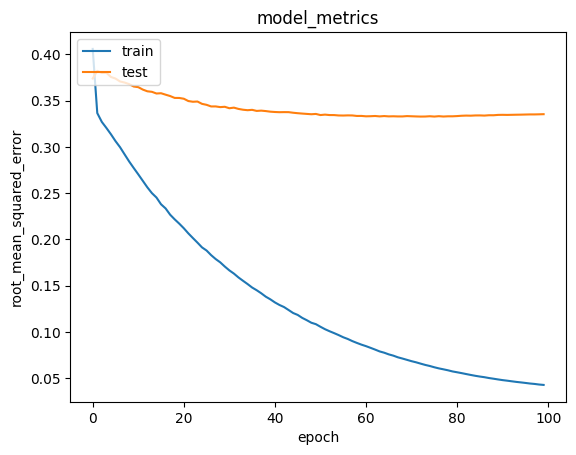

In [ ]:
plt.plot(hist.history['root_mean_squared_error'])
plt.plot(hist.history['val_root_mean_squared_error'])
plt.title('model_metrics')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Mendapatkan Rekomendasi

In [ ]:
product_df = pd.merge(raw_products,
                      raw_order_items[['product_id',
                                       'seller_id']].drop_duplicates('product_id'),
                      on='product_id', how='left')
df2 = df

# Mengambil sample user
user_id = df2.groupby('customer_unique_id').count()
user_id = user_id[user_id['product_id'] > 5].sample(1).index[0]

# user_id = df2.customer_unique_id.sample(1).iloc[0]
product_bought_by_user = df2[df2.customer_unique_id == user_id]

product_not_bought = product_df[~product_df['product_id'].isin(product_bought_by_user.product_id.values)]['product_id'] 
product_not_bought = list(
    set(product_not_bought)
    .intersection(set(product_to_product_encoded.keys()))
)

product_not_bought = [[product_to_product_encoded.get(x)] for x in product_not_bought]
user_encoder = user_to_user_encoded.get(user_id)
user_product_array = np.hstack(
    ([[user_encoder]] * len(product_not_bought), product_not_bought)
)

# predict rekomendasi
ratings = model.predict(user_product_array).flatten()

top_ratings_indices = ratings.argsort()[-10:][::-1]
top_ratings_indices

recommended_product_ids = [
    product_encoded_to_product.get(product_not_bought[x][0]) for x in top_ratings_indices
]

print('\nShowing recommendations for users:\n{}'.format(user_id))
print('===' * 9)
 
top_product_user = (
    product_bought_by_user.drop_duplicates('product_id')
    .sort_values(
        by = 'review_score',
        ascending=False
    )
    .head(5)
    .product_id.values
)

print('\n\nProduct with high reviews from user')
product_df_rows = product_df[product_df['product_id'].isin(top_product_user)]
for row in product_df_rows.itertuples():
    print(row.product_id, ':', row.product_category_name)

print('\n\nTop 10 product recommendation')

recommended_product = product_df[product_df['product_id'].isin(recommended_product_ids)]
for i, row in enumerate(recommended_product.itertuples()):
    print(i+1, '.', row.product_id, '\t:', row.product_category_name,
          '\n   ', row.seller_id)

984/984 [==============================] - 2s 2ms/step

Showing recommendations for users:
bf429f20c75a39eab83442cda8e59832


Product with high reviews from user
product_10362 : sports_leisure


Top 10 product recommendation
1 . product_9949 	: furniture_decor 
    seller_443
2 . product_5630 	: fixed_telephony 
    seller_1043
3 . product_31762 	: small_appliances 
    seller_2915
4 . product_29040 	: stationery 
    seller_1787
5 . product_11817 	: health_beauty 
    seller_1210
6 . product_16087 	: stationery 
    seller_668
7 . product_21496 	: fashion_bags_accessories 
    seller_1277
8 . product_7408 	: housewares 
    seller_1815
9 . product_8130 	: baby 
    seller_434
10 . product_9125 	: stationery 
    seller_157


In [ ]:
df2[df2['customer_unique_id'] == user_id]

,product_id,seller_id,price,review_score,respons_time_order,customer_unique_id,customer_city,product_category_name,seller_city,sold,customer,product
21505,product_10362,seller_785,105.0,5,0 days 02:04:03,bf429f20c75a39eab83442cda8e59832,santo angelo,sports_leisure,curitiba,13,18440,3408
21506,product_10362,seller_785,105.0,5,0 days 02:04:03,bf429f20c75a39eab83442cda8e59832,santo angelo,sports_leisure,curitiba,13,18440,3408
21507,product_10362,seller_785,105.0,5,0 days 02:04:03,bf429f20c75a39eab83442cda8e59832,santo angelo,sports_leisure,curitiba,13,18440,3408
21515,product_10362,seller_438,104.9,5,0 days 00:39:50,bf429f20c75a39eab83442cda8e59832,santo angelo,sports_leisure,sao joao de meriti,13,18440,3408
21516,product_10362,seller_438,104.9,5,0 days 00:39:50,bf429f20c75a39eab83442cda8e59832,santo angelo,sports_leisure,sao joao de meriti,13,18440,3408
21517,product_10362,seller_438,104.9,5,0 days 00:39:50,bf429f20c75a39eab83442cda8e59832,santo angelo,sports_leisure,sao joao de meriti,13,18440,3408
